In [1]:

import pandas as pd
import numpy as np

from scipy import stats

import os 

os.chdir("../../scripts/PXD002952")

from q_value import qvalues
from triqler_output_to_df import  parse_triqler

os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/full_ts_v")


# filename has different formatting, we need to change number or implement regex.
experiment_id_mapper = lambda x: x.split("_")[5]
sample_id_mapper = lambda x: x.split("_")[8] #hye124 
specie_mapper = lambda x: x.split("_")[-1]

def read_in_and_filter(filename, m_score_treshold = 0.01):  
    print(filename)
    df = pd.read_csv(filename, sep = "\t")
    df = df[df.decoy != 1]
    df = df[df.m_score < m_score_treshold] # filter away crap, so all values should be good... we take average of top3 here
    print(str(len(df)) + " significantly identified peptides at " + str(m_score_treshold) + " FDR-treshold.")
    print("")
    df["experiment_id"] = df["filename"].map(experiment_id_mapper)
    df["sample_id"] = df["filename"].map(sample_id_mapper)
    sample_id = df.sample_id[0]
    experiment_id = df.experiment_id[0]     
    def top3(df):
        df = (df.groupby('ProteinName')['Intensity'].apply(lambda x: x.nlargest(3).mean() if len(x.nlargest(3)) >= 2 else np.nan)
                  .reset_index())
        #print(df.isna().sum())
        return df
    df_reduced = df[["ProteinName", "Intensity"]]
    df_protein = top3(df_reduced)
    df = df_protein
    df["specie"] = df.ProteinName.map(specie_mapper)
    midx = pd.MultiIndex(levels = [[sample_id],[experiment_id]], codes = [[0],[0]], names = ["sample_id", "experiment_id"])
    df = df.set_index(["specie", "ProteinName"])
    df = pd.DataFrame(df.values, columns = midx, index = df.index)
    
    return df



# highest scoring vs top highest intenstiy peptide?
# We take top3 intensity because we filter away so much with m_score < 0.01, all values should be good.

dfs = []
for file in os.listdir():
    if file[-4:] == ".tsv":
        dfs.append(read_in_and_filter(file, m_score_treshold=0.01))
        #print(len(df_part))
        #df = pd.concat([df, df_part],axis = 1)        
df = pd.concat(dfs, axis = 1)


HYE124_TTOF6600_32fix_lgillet_I150211_005-Pedro_-_Sample_2_-_SW32_-_Repl2.mzML.tsv
33070 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_006-Pedro_-_Sample_1_-_SW32_-_Repl3.mzML.tsv
31895 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_003-Pedro_-_Sample_2_-_SW32_-_Repl1.mzML.tsv
32521 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_004-Pedro_-_Sample_1_-_SW32_-_Repl2.mzML.tsv
31588 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_007-Pedro_-_Sample_2_-_SW32_-_Repl3.mzML.tsv
33516 significantly identified peptides at 0.01 FDR-treshold.

HYE124_TTOF6600_32fix_lgillet_I150211_002-Pedro_-_Sample_1_-_SW32_-_Repl1.mzML.tsv
31707 significantly identified peptides at 0.01 FDR-treshold.



In [2]:
A = df[df.iloc[:, df.columns.get_level_values("sample_id") == "1"].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == "1"]
A = np.log2(A)
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == "2"].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == "2"]
B = np.log2(B)


array([[<AxesSubplot:title={'center':'1'}>]], dtype=object)

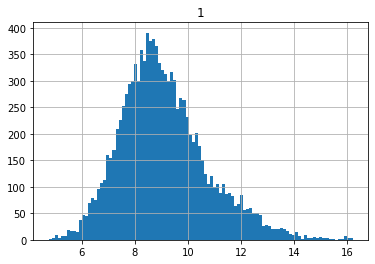

In [3]:
A.stack().hist(bins = 100)


array([[<AxesSubplot:title={'center':'2'}>]], dtype=object)

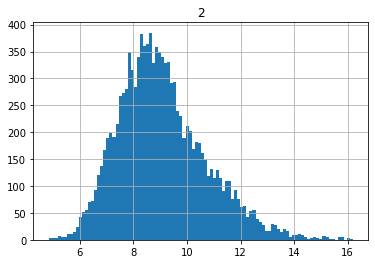

In [4]:
B.stack().hist(bins = 100)


Intensities of multiply charged precursors were summed up, and averaged between technical replicates of each sample. Protein quantities were estimated in each technical replicate bythe average of the most 3 intense peptides reported for each protein. Single hit proteins (asingle peptide detected in a protein) and proteins detected in less than two injections inboth samples A and B were discarded.

In [5]:
print("Protein identified " + str(len(A.sum(axis=1).dropna())) + " in iteration 1.")

Protein identified 3891 in iteration 1.


In [6]:
print("Protein identified " + str(len(B.sum(axis=1).dropna())) + " in iteration 2.")

Protein identified 3994 in iteration 2.


In [7]:
# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]

import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)


<AxesSubplot:xlabel='p', ylabel='q'>

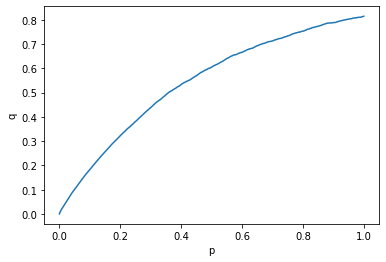

In [8]:
import seaborn as sns
sns.lineplot(x = "p", y = "q", data=p_vals)


In [9]:

A = A.sum(axis=1)
B = B.sum(axis=1)

A.name = "1"
B.name = "2"

df_final = pd.concat([A, B, p_vals], axis = 1)



df_final["log2(A,B)"] = df_final["1"] - df_final["2"]
df_h = df_final.iloc[df_final.index.get_level_values("specie") == "HUMAN", :]
df_y = df_final.iloc[df_final.index.get_level_values("specie") == "YEAS8", :]
df_e = df_final.iloc[df_final.index.get_level_values("specie") == "ECOLI", :]


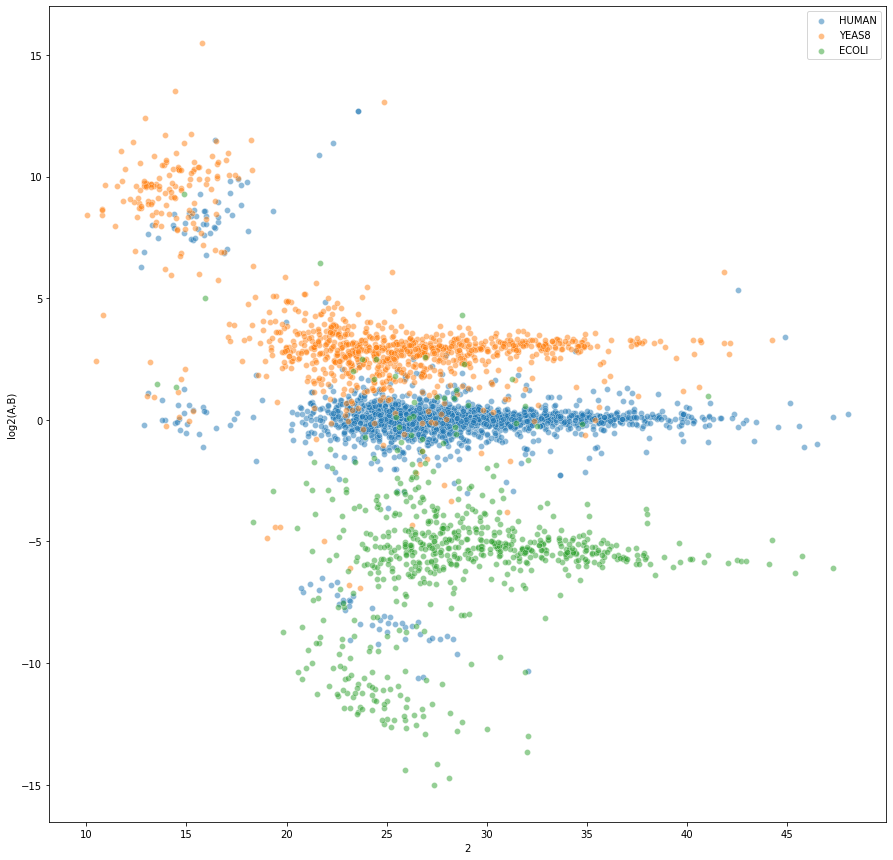

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(1, 1, figsize=(15,15))
sns.scatterplot(ax = ax, data = df_h, x = "2", y = "log2(A,B)", alpha = 0.5)
sns.scatterplot(ax = ax, data = df_y, x = "2", y = "log2(A,B)", alpha = 0.5)
sns.scatterplot(ax = ax, data = df_e, x = "2", y = "log2(A,B)", alpha = 0.5)
plt.legend(labels=['HUMAN', 'YEAS8', 'ECOLI'])



If we log before summing we get above plot...But if we sum before logging we get the below plot... which is similar to the LFQ bench paper.

In [11]:

A = df[df.iloc[:, df.columns.get_level_values("sample_id") == "1"].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == "1"]
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == "2"].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == "2"]

# Find overlapping proteins
overlapping_proteins = list(set(A.index) & set(B.index))
A = A[A.index.isin(overlapping_proteins)]
B = B[B.index.isin(overlapping_proteins)]

import scipy.stats as stats

p_vals = stats.ttest_ind(A, B, axis = 1)[1]
p_vals = pd.DataFrame(p_vals, columns = ["p"])
p_vals["q"] = qvalues(p_vals)
p_vals = pd.DataFrame(p_vals.values, index = A.index, columns = ["p", "q"])
p_vals.sort_values("q",inplace =True)
p_vals = p_vals.astype(float)

In [12]:
A = df[df.iloc[:, df.columns.get_level_values("sample_id") == "1"].isna().sum(axis=1)<2]
A = A.iloc[:,A.columns.get_level_values("sample_id") == "1"]
B = df[df.iloc[:, df.columns.get_level_values("sample_id") == "2"].isna().sum(axis=1)<2]
B = B.iloc[:,B.columns.get_level_values("sample_id") == "2"]
A = np.log2(A.sum(axis=1))
B = np.log2(B.sum(axis=1))
A.name = "1"
B.name = "2"
df_final = pd.concat([A, B, p_vals], axis = 1)
df_final["log2(A,B)"] = df_final["1"] - df_final["2"]
df_h = df_final.iloc[df_final.index.get_level_values("specie") == "HUMAN", :]
df_y = df_final.iloc[df_final.index.get_level_values("specie") == "YEAS8", :]
df_e = df_final.iloc[df_final.index.get_level_values("specie") == "ECOLI", :]

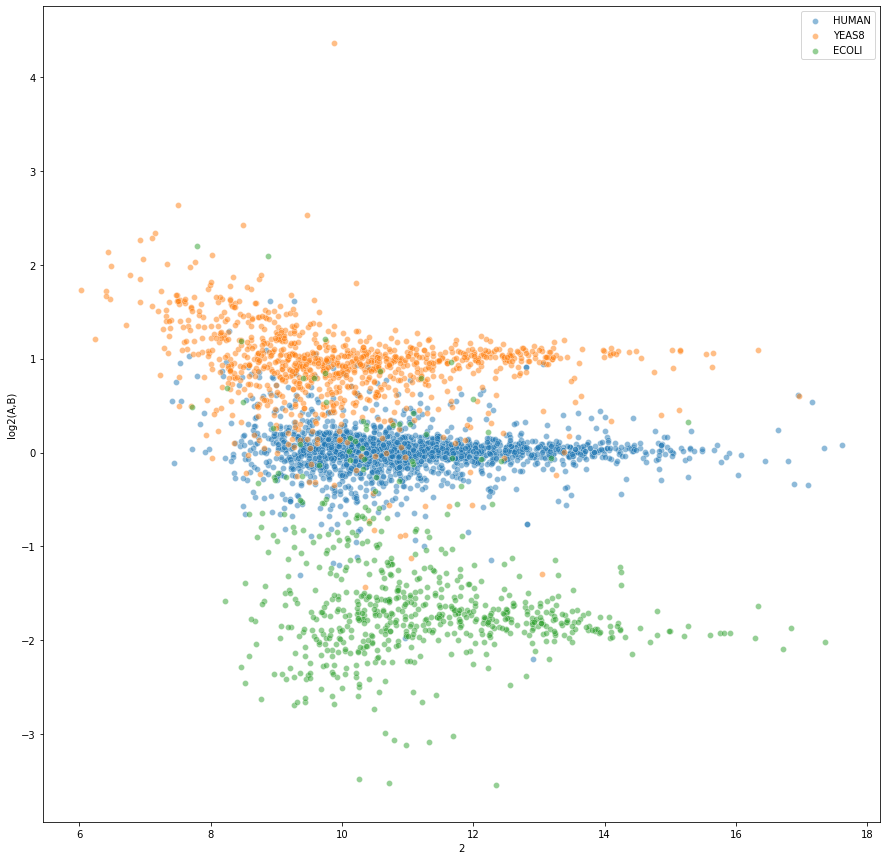

In [13]:


f, ax = plt.subplots(1, 1, figsize=(15,15))

sns.scatterplot(ax = ax, data = df_h, x = "2", y = "log2(A,B)", alpha = 0.5)
sns.scatterplot(ax = ax, data = df_y, x = "2", y = "log2(A,B)", alpha = 0.5)
sns.scatterplot(ax = ax, data = df_e, x = "2", y = "log2(A,B)", alpha = 0.5)
plt.legend(labels=['HUMAN', 'YEAS8', 'ECOLI'])



In [14]:
def plot_n_DE(df):
    n_array = []
    for fc in np.arange(0,2.05,0.05):
        n_gt = (df["log2(A,B)"] > fc).sum()
        n_lt = (df["log2(A,B)"] < -fc).sum()
        n = n_gt + n_lt
        df["log2(A,B)"].between(-fc, fc, inclusive=True)
        n_array.append(n)
    
    n_de = pd.DataFrame([n_array, np.arange(0,2.05,0.05)], index = ["n", "fc_treshold"])
    plt.plot(np.arange(0,2.05,0.05), n_array)

df_final_q = df_final[df_final["q"]<0.01]



In [15]:

os.chdir("/hdd_14T/data/PXD002952/osw_res_20210303/hye124/ttof6600/32fix/triqler_results")

fc_tresh = []
n_hs = []
n_ye = []
n_ec = []

for file in sorted(os.listdir()):       
    fc = float(file.split("_")[1])
    df_triq = parse_triqler(file)
    df_triq = df_triq[df_triq.q_value < 0.01]
    df_triq["specie"] = df_triq.protein.map(specie_mapper)
    n_hs.append((df_triq["specie"] == "HUMAN").sum())
    n_ye.append((df_triq["specie"] == "YEAS8").sum())
    n_ec.append((df_triq["specie"] == "ECOLI").sum())
    fc_tresh.append(fc)





Text(0.5, 1.0, 'HUMAN')

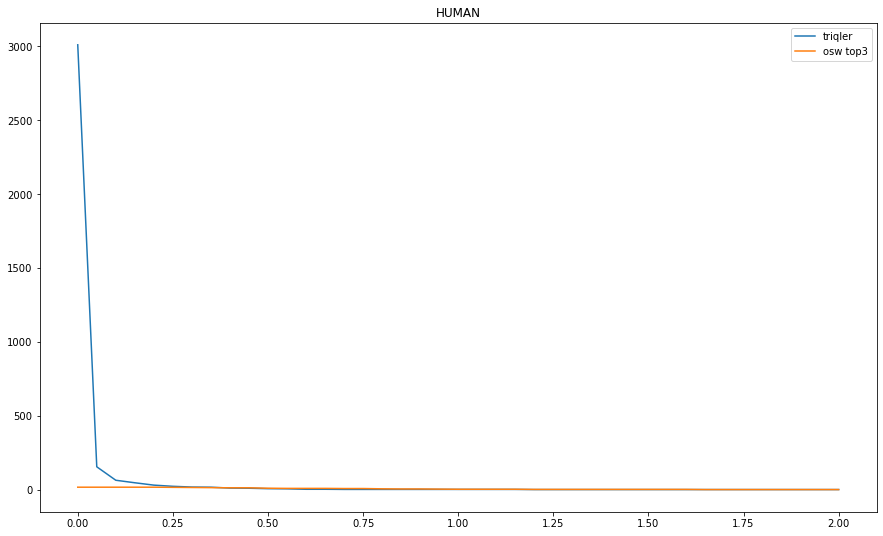

In [20]:
f, ax = plt.subplots(1, 1, figsize=(15,9))
plt.plot(fc_tresh, n_hs)
plot_n_DE(df_final_q.iloc[df_final_q.index.get_level_values("specie") == "HUMAN",:])
plt.legend(labels=['triqler', 'osw top3'])
plt.title("HUMAN")

Text(0.5, 1.0, 'YEAST')

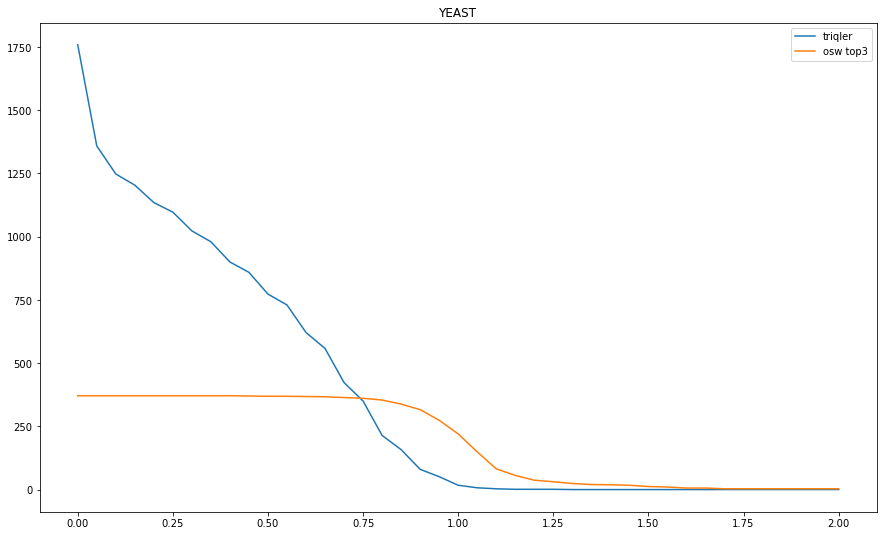

In [21]:
f, ax = plt.subplots(1, 1, figsize=(15,9))
plt.plot(fc_tresh, n_ye)
plot_n_DE(df_final_q.iloc[df_final_q.index.get_level_values("specie") == "YEAS8",:])
plt.legend(labels=['triqler', 'osw top3'])
plt.title("YEAST")

Text(0.5, 1.0, 'ECOLI')

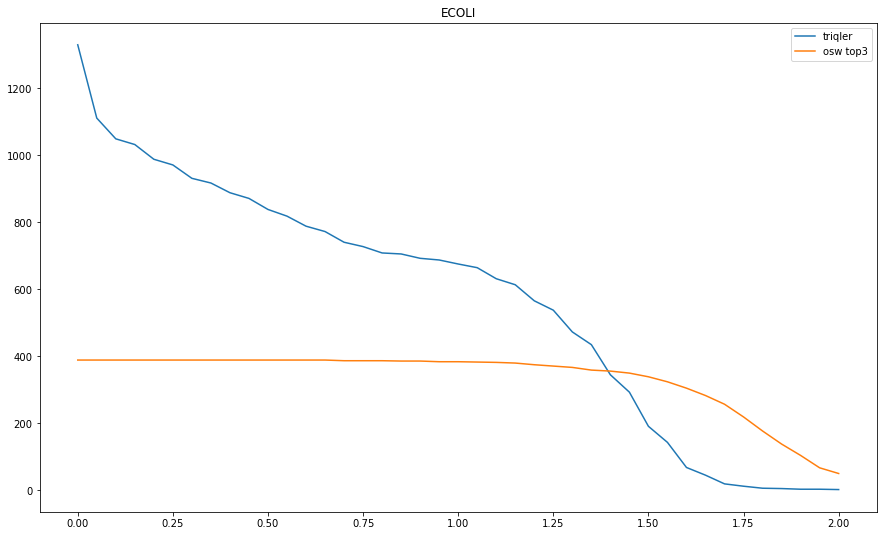

In [22]:
f, ax = plt.subplots(1, 1, figsize=(15,9))
plt.plot(fc_tresh, n_ec)
plot_n_DE(df_final_q.iloc[df_final_q.index.get_level_values("specie") == "ECOLI",:])
plt.legend(labels=['triqler', 'osw top3'])
plt.title("ECOLI")

Text(0.5, 1.0, 'Triqler')

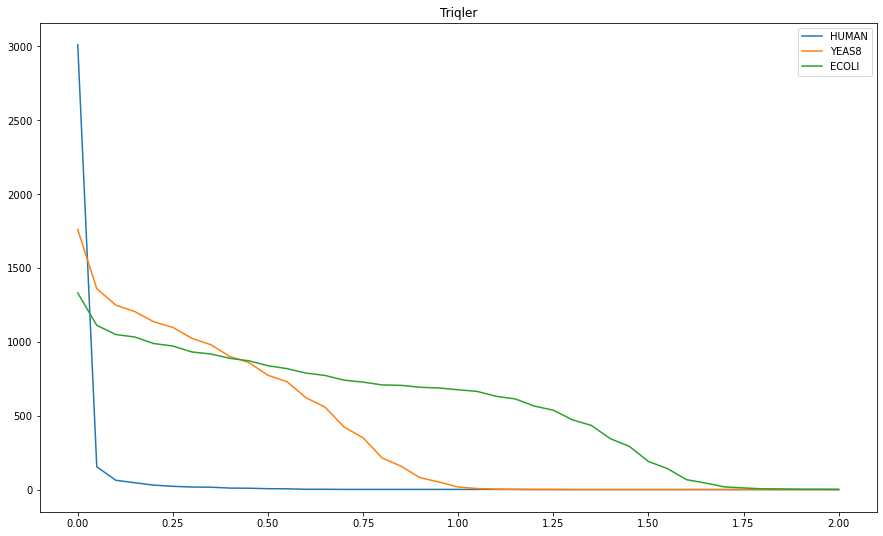

In [24]:
f, ax = plt.subplots(1, 1, figsize=(15,9))
plt.plot(fc_tresh, n_hs)
plt.plot(fc_tresh, n_ye)
plt.plot(fc_tresh, n_ec)
plt.legend(labels=['HUMAN', 'YEAS8', 'ECOLI'])
plt.title("Triqler")


Text(0.5, 1.0, 'OSW top3')

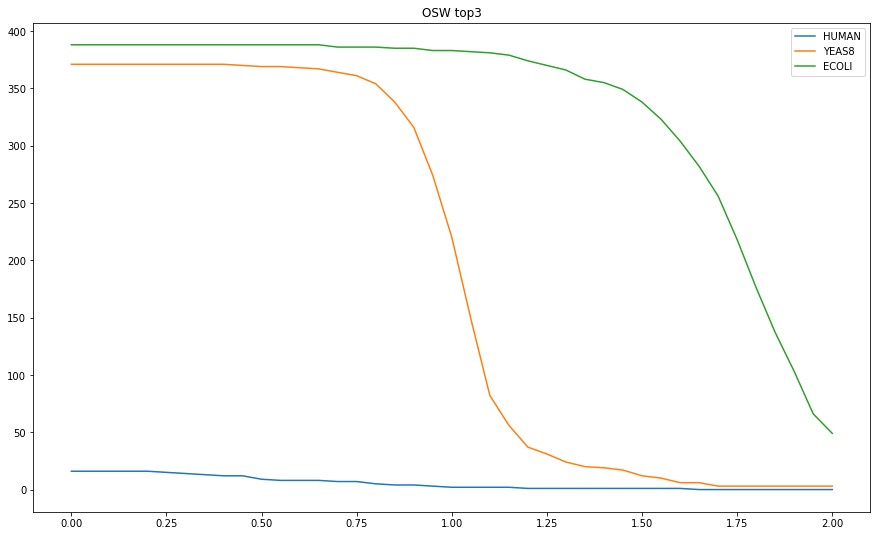

In [25]:
f, ax = plt.subplots(1, 1, figsize=(15,9))
plot_n_DE(df_final_q.iloc[df_final_q.index.get_level_values("specie") == "HUMAN",:])
plot_n_DE(df_final_q.iloc[df_final_q.index.get_level_values("specie") == "YEAS8",:])
plot_n_DE(df_final_q.iloc[df_final_q.index.get_level_values("specie") == "ECOLI",:])
plt.legend(labels=['HUMAN', 'YEAS8', 'ECOLI'])
plt.title("OSW top3")